In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from LDMM import LDMNetSkorch, LDMNetDummy, LDMNetReg, plot_over_time
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import EarlyStopping, NaNStopping, MLP
from skorch.callbacks import LRScheduler

from sklearn.decomposition import PCA

random_state=0


### On the dummy model
- ksi = X is fixed all the time.
- L and W depend on ksi only, so they remain constant
- Z starts with 0
- Let M = c(L+ cW)^-1 W
- alpha_1 = M ksi
- Z_1 = alpha_1 - ksi
- alpha_2 = M (ksi - Z_1) = M (2*ksi - alpha_1)
- alpha_k+1 = M(2*ksi - alpha_k)
    - linear model x_k+1 = Ax_k + u_k, A = -M
    - eigen values of A all < 1 --> stable
    
### On the reg only model
- ksi starts with X, Z = 0 and alpha ?
- alpha_1 = Mk ksi_0
- ksi_1 = ksi_0 -lr * mu * (ksi_0 - Z_0 + alpha_1)
- Z_1 = Z_0 + alpha_1 - ksi_1
- alpha_1 = Mk ksi_1 - Mk Z_1
- M changes every k because it depends on ksi. If lr is low, ksi and M should not change too much.

## S curve

In [3]:
from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=100, noise=0, random_state=random_state)
hist, bin_edges = np.histogram(y, bins=2)
y = np.digitize(y, bin_edges)-1
X.shape, y.shape

((100, 3), (100,))

(-2.0802723413954554,
 2.340721157613356,
 -1.1241643227215465,
 3.2968291762872646)

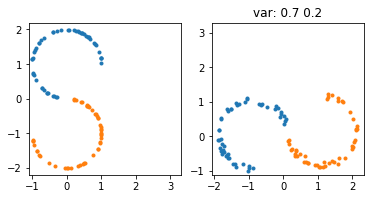

In [4]:
plt.figure()
plt.subplot(1,2, 1)
plt.plot(*X[y==0][:,[0,2]].T, '.')
plt.plot(*X[y==1][:,[0,2]].T, '.')
plt.axis('square')
proj = PCA(n_components=2, random_state=random_state)
X2d = proj.fit_transform(X)


plt.subplot(1,2, 2)
plt.plot(*X2d[y==0].T, '.')
plt.plot(*X2d[y==1].T, '.')
plt.title("var: %0.1f %0.1f" % tuple(proj.explained_variance_ratio_[0:2]))
plt.axis('square')

### Dummy model

In [5]:
dummy_model = LDMNetDummy(mu=1, lambda_bar=1, concatenate_input=False)

In [6]:
W = dummy_model._compute_W(X)
L = dummy_model._compute_L(W)
c = dummy_model.mu/dummy_model.lambda_bar
# Solve Ax = b
A = (L + c*W).tocsc()
invA = sparse.linalg.spilu(A, drop_tol=1e-5, fill_factor=50)
M = c * invA.solve(W.todense())
np.abs(np.linalg.eigvals(M)), np.all(np.abs(np.linalg.eigvals(M) < 1.0))

(array([1.        , 0.9820234 , 0.88162513, 0.8567371 , 0.67035758,
        0.57131329, 0.55193292, 0.4801176 , 0.43096956, 0.38597983,
        0.30748433, 0.25045822, 0.2061886 , 0.1563757 , 0.14981664,
        0.11483863, 0.06682899, 0.0541498 , 0.03445259, 0.02355191,
        0.00493939, 0.02185736, 0.03013377, 0.04561916, 0.05104403,
        0.15239987, 0.06521863, 0.06961438, 0.07780002, 0.08043399,
        0.08043399, 0.1340625 , 0.1340625 , 0.08196597, 0.13199909,
        0.13199909, 0.08598811, 0.08598811, 0.12979632, 0.12979632,
        0.1182054 , 0.1182054 , 0.12746225, 0.12746225, 0.08715179,
        0.09236585, 0.09236585, 0.09729545, 0.09729545, 0.12125222,
        0.12125222, 0.10179957, 0.10179957, 0.11535796, 0.11535796,
        0.12413127, 0.09934396, 0.09934396, 0.12122509, 0.12122509,
        0.12325642, 0.12325642, 0.1069497 , 0.1069497 , 0.08977412,
        0.12168706, 0.12168706, 0.09077309, 0.09077309, 0.11583559,
        0.11583559, 0.10639432, 0.10639432, 0.11

In [7]:
dummy_model.fit(X,y)

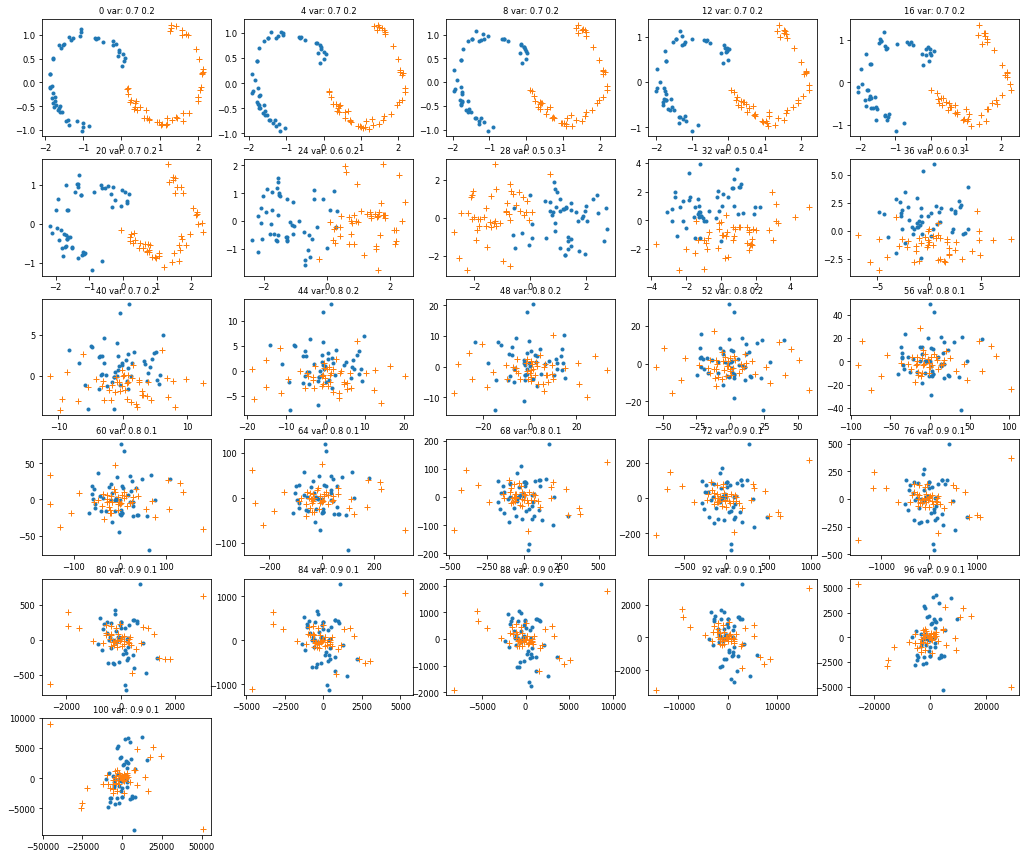

In [8]:
plot_over_time(dummy_model, 'alpha', every_n=4, y=y)

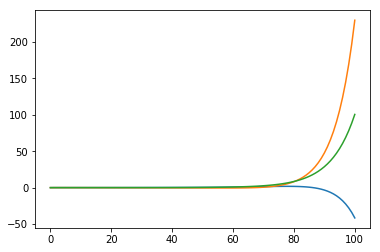

In [9]:
Z = np.stack(dummy_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

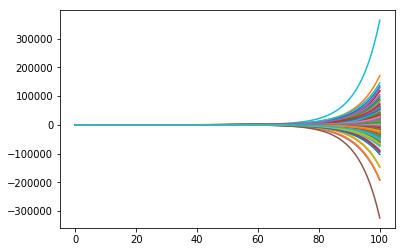

In [10]:
Z = np.stack(dummy_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)

### Only reg loss model

In [11]:
reg_model = LDMNetReg(mu=1e-4, lambda_bar=1e-3, lr=1, max_epochs=600)
ksi = reg_model.fit_transform(X,y)

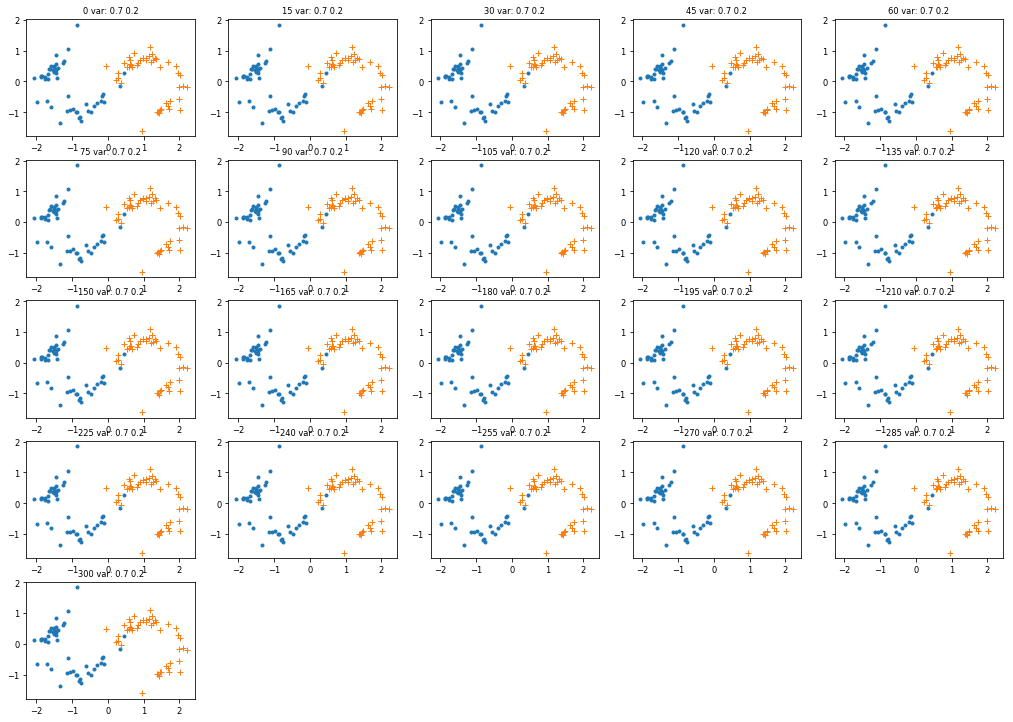

In [12]:
plot_over_time(reg_model, 'ksi', every_n=15, y=y)

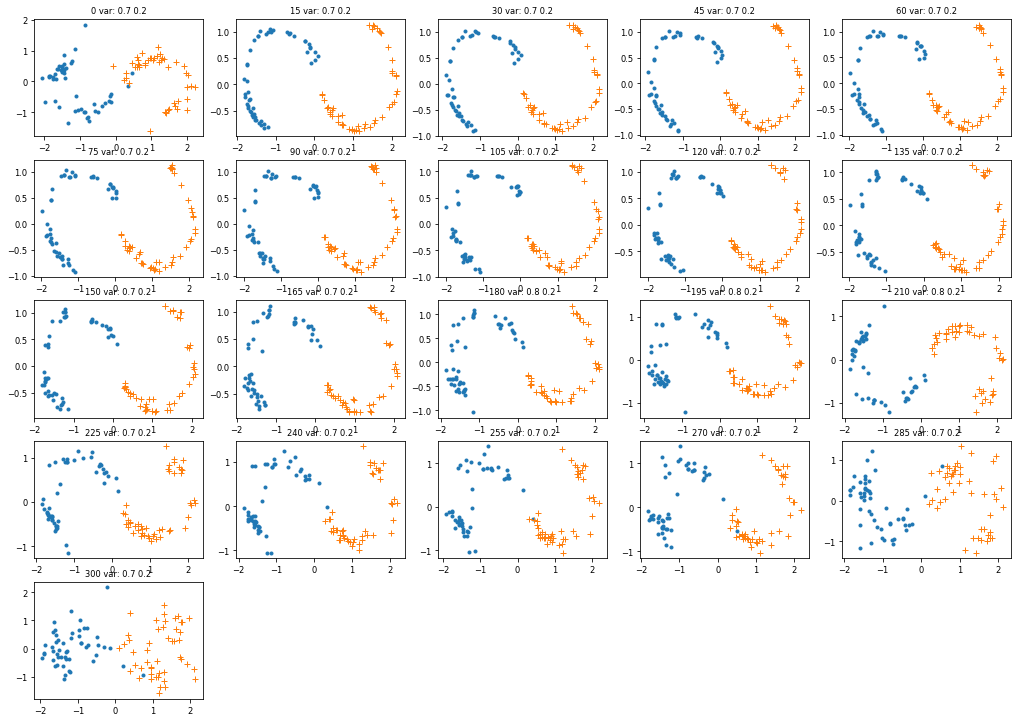

In [16]:
plot_over_time(reg_model, 'alpha', every_n=15, y=y)

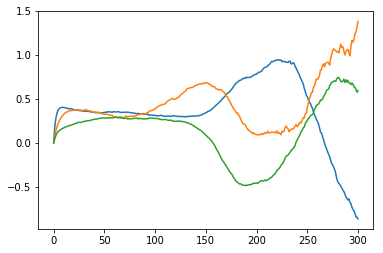

In [14]:
Z = np.stack(reg_model.Z, axis=-1)
Z = Z.transpose([1,0,2])
plt.figure()
for feature in Z:
    plt.plot(feature.mean(axis=0))

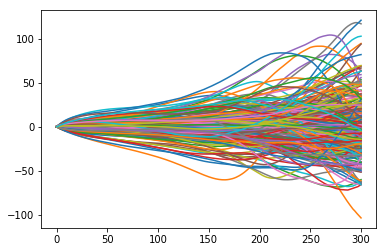

In [15]:
Z = np.stack(reg_model.Z, axis=-1)
plt.figure()
for sample in Z:
    for feature in sample:
        plt.plot(feature)